# Classification of Breast Cancer using ResNet

- Data Preparation: Organizing the dataset, creating a data loader for processing.
- Model Selection: Choosing an appropriate pre-trained model and modifying it if necessary.
- Loss Function and Optimizer Selection: Selecting appropriate criteria for training the model.
- Training the Model: Writing the training loop, handling forward and backward propagation.
- Validation and Testing: Evaluating the model on the validation set and testing its generalization on unseen data.
- Performance Metrics: Implementing metrics like accuracy, precision, recall, and F1-score to evaluate the model.
- Fine-tuning and Model Improvement: Based on initial results, tuning the model to improve accuracy.
- Deployment: Steps to prepare the model for deployment, if applicable.

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split,  Dataset
from torch.utils.data import DataLoader, Subset
import torch.nn as nn

import numpy as np
import config
import os
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
from itertools import cycle

In [ ]:
# Checking which device we are using

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available() :
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using: {device}")

Using: cuda


First of all we want to check the mode of images, which gives insight into the number of channels they carry.

In [ ]:
def check_image_mode(image_path):
    with Image.open(image_path) as img:
        mode = img.mode
        print(f"The mode of the image '{image_path}' is: {mode}")
        if mode == 'L':
            print(f"The image at {image_path} is grayscale.")
        elif mode == 'RGB':
            print(f"The image at {image_path} is colorful (RGB).")
        else:
            print(f"The image at {image_path} is in {mode} mode, which is not standard for grayscale or RGB.")

image_path = 'data/raw/benign/benign (434).png'
check_image_mode(image_path)

The mode of the image 'data/raw/benign/benign (434).png' is: RGB
The image at data/raw/benign/benign (434).png is colorful (RGB).


Let us load our data using the ImageFolder function.

In [ ]:
# Load the datasets with ImageFolder
dataset = datasets.ImageFolder(root=config.PTH_DATA)

In [ ]:
# Filter out images with '_mask' in their filenames
filtered_samples = [sample for sample in dataset.samples if '_mask' not in os.path.basename(sample[0])]
dataset.samples = filtered_samples

In [ ]:
dataset.samples[:5]

[('/home/default/Desktop/raw/benign/benign (1).png', 0),
 ('/home/default/Desktop/raw/benign/benign (10).png', 0),
 ('/home/default/Desktop/raw/benign/benign (100).png', 0),
 ('/home/default/Desktop/raw/benign/benign (101).png', 0),
 ('/home/default/Desktop/raw/benign/benign (102).png', 0)]

## Data Transformation Strategies

### Training Data Transformations
The training data undergoes a series of transformations to enhance the model's ability to generalize from the training dataset to unseen data. This is achieved through:
- *Resizing and cropping* to maintain consistency in image dimensions across all inputs, which is crucial for the neural network to process them effectively.
- *Data augmentation techniques* like random flips and rotations introduce variability into the dataset, simulating different viewing conditions. This helps prevent the model from overfitting and improves its robustness and performance on new, unseen images.

### Testing Data Transformations
For the testing data, transformations are kept minimal to evaluate the model's performance under consistent and controlled conditions:
- *Resizing and center cropping* are applied to match the input size used during training, ensuring that each image is evaluated in a uniform manner.
- *No random augmentations* are used in testing to ensure the data reflects real-world scenarios without artificial modifications.

These transformations are essential for preparing the images in a format suitable for the neural network and facilitate both effective training and accurate evaluation.

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(), # Data augmentation
    transforms.RandomVerticalFlip(), # Data augmentation
    transforms.RandomRotation(10) # Data augmentation
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [ ]:
# Splitting the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Applying different transforms to the test dataset
train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = test_transforms

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Extract class labels
class_labels = dataset.classes
print(f"Class labels: {class_labels}")

Class labels: ['benign', 'malignant', 'normal']


## Residual Networks

Our next step is to load a pretrained ResNet model and apply some modifications to it to have the mask of the image as an additional input channel.

In [ ]:
# Load a pretrained ResNet model
model = models.resnet18(pretrained=True)

# for param in model.parameters():
    # param.requires_grad = False

# Modify the final fully connected layer to match the number of classes
num_features = model.fc.in_features  # Get the number of input features of the last layer
model.fc = nn.Linear(num_features, 3)  # 3 classes: no cancer, benign, malignant

model = model.to(device)

/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Model Training Components

### Loss Function
**CrossEntropyLoss**: Used as the loss function, it is particularly suited for classification tasks with multiple classes. This function calculates the difference between the predicted probabilities and the true distribution (the actual labels), effectively measuring the performance of the model during training. The goal is to minimize this loss, which indicates better model predictions.

### Optimizer
**Stochastic Gradient Descent (SGD)**: The optimizer chosen to update the model's weights based on the gradients of the loss function. Specific parameters include:
  - **Learning Rate (0.001)**: Determines how much to change the model in response to the estimated error each time the model weights are updated.
  - **Momentum (0.9)**: Helps to accelerate gradients vectors in the right directions, thus leading to faster converging. It incorporates the 'velocity' of the gradients to smooth out the updates.
  - **Nesterov Accelerated Gradient (Nesterov=True)**: An improvement on traditional momentum, it looks ahead by calculating gradient not at the current parameters but at the lookahead parameters.
  - **Weight Decay (0.00001)**: Adds a regularization term to the loss to prevent the weights from growing too large; only weights need to be regularized.

### Learning Rate Scheduler
**StepLR**: Adjusts the learning rate according to a step policy, useful for controlling and adjusting the learning rate during training:
  - **Step Size (10)**: The learning rate is decayed every 10 epochs.
  - **Gamma (0.1)**: Determines the factor by which the learning rate will be reduced. Every 10 epochs, the learning rate is multiplied by 0.1, effectively dropping the learning rate to prevent overshooting the minimum of the loss landscape as the training progresses.

Note that the specific hyperparameters were chosen based on their performance.


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

## Training and Testing

In [ ]:
for epoch in range(30):

    # Setting the model to training mode
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass: Compute predicted label by passing the image to the model
        output = model(images)

        # Compute loss
        loss = criterion(output, labels)

        # Backpropagation steps
        optimizer.zero_grad() # Clear gradients before calculating them
        loss.backward() # Calculate gradients
        optimizer.step() # Update model parameters

    # Validation every 5 epochs
    if epoch % 5 != 0:
        continue

    print(f"Epoch {epoch}/30")
    print("-" * 10)
    print(f'Epoch {epoch} loss: {loss.item()}')

    scheduler.step()

    # Setting the model to evaluation mode
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch} accuracy: {correct / total}')
    print()

Epoch 0/30
----------
Epoch 0 loss: 0.9691269397735596
Epoch 0 accuracy: 0.5448717948717948

Epoch 5/30
----------
Epoch 5 loss: 0.162851944565773
Epoch 5 accuracy: 0.8012820512820513

Epoch 10/30
----------
Epoch 10 loss: 0.024725833907723427
Epoch 10 accuracy: 0.8141025641025641

Epoch 15/30
----------
Epoch 15 loss: 0.016260337084531784
Epoch 15 accuracy: 0.8397435897435898

Epoch 20/30
----------
Epoch 20 loss: 0.016421716660261154
Epoch 20 accuracy: 0.8269230769230769

Epoch 25/30
----------
Epoch 25 loss: 0.003186807967722416
Epoch 25 accuracy: 0.8269230769230769



## Model Evaluation

During the evaluation phase, the model is set to `model.eval()` mode to deactivate dropout and normalize with batch statistics, ensuring consistent behavior. Using `torch.no_grad()`, the model predicts over the test set, computing loss and key metrics like accuracy, precision, recall, and F1 score. This step is crucial for assessing the model's performance on unseen data, highlighting its effectiveness and areas for potential improvement.

In [ ]:
model.eval()

with torch.no_grad():
    all_preds = []
    all_labels = []
    test_loss = 0.0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)

    accuracy = accuracy_score(all_labels, all_preds)

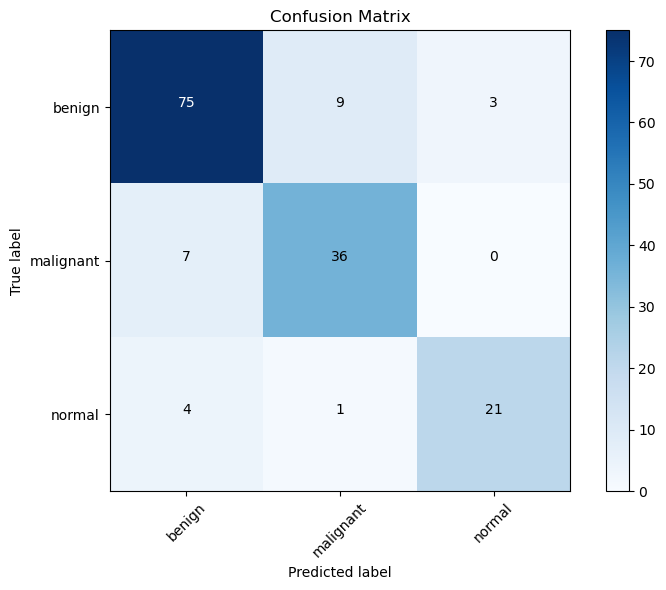

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(dataset.classes))
plt.xticks(tick_marks, dataset.classes, rotation=45)
plt.yticks(tick_marks, dataset.classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f'{cm[i, j]}',
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

The confusion matrix shows the classification performance for the three categories.

The model is highly effective at identifying normal cases with high accuracy.

Results for cancerous scans are still impressive. However, some confusion between benign and malignant classes suggests the need for improved feature distinction or model tuning to better differentiate these conditions.

## ROC Curve
A Receiver Operating Characteristic (ROC) curve is a graphical plot used to show the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots two parameters:
- **True Positive Rate (TPR)**: Also known as sensitivity, it measures the proportion of actual positives correctly identified by the model.
- **False Positive Rate (FPR)**: Measures the proportion of actual negatives that are incorrectly classified as positives.

They provide an overview of the trade-off between sensitivity (TPR) and specificity (1 - FPR) across different thresholds. The area under the ROC curve (AUC) gives a single scalar value to rate performance. A higher AUC value indicates a better performing model, with 1.0 representing perfect prediction and 0.5 denoting a result no better than random chance.

This tool is crucial in evaluating and comparing the performance of different classification models, especially in fields like medicine where the costs of false negatives and false positives are significantly different.

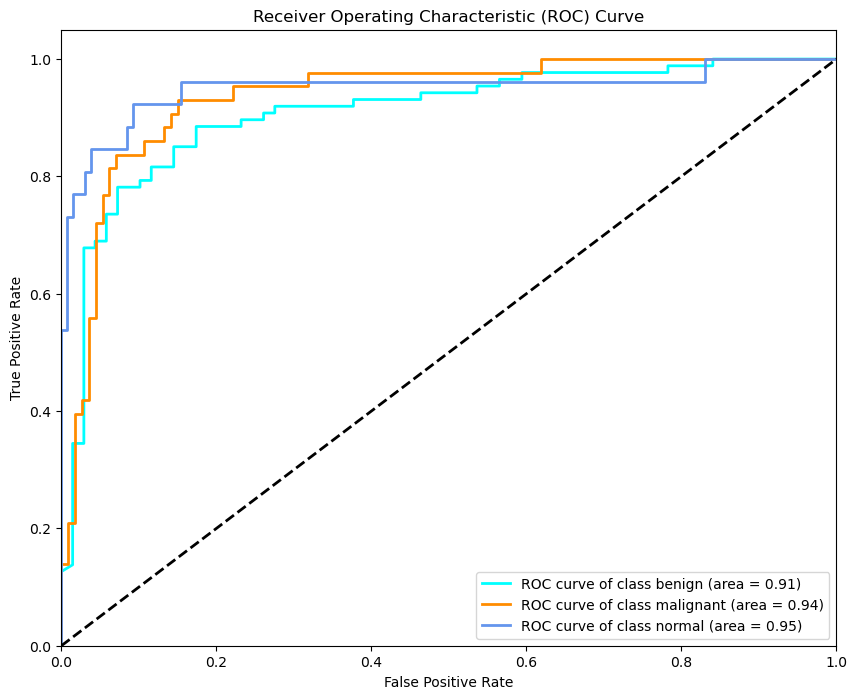

In [ ]:
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Binarize the labels
n_classes = len(dataset.classes)
all_labels_binarized = label_binarize(all_labels, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {dataset.classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from datetime import datetime
model_pth_name = os.path.join(config.PTH_SAVED_MODELS, datetime.now().strftime('%Y-%m-%d_%H:%M:%S') + '_model.pth')
torch.save(model, model_pth_name)